# Cell segmentation

In [1]:
import gzip

import cv2
import matplotlib.pyplot as plt
import numpy as np
import skimage
import sklearn
import spateo as st
from scipy import ndimage

plt.rcParams['image.interpolation'] = 'none'
%config InlineBackend.figure_format='retina'

/Users/josephmin/miniconda3/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/Users/josephmin/miniconda3/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:366: NumbaWarning: The TBB threading layer requires TBB version 2021 update 1 or later i.e., TBB_INTERFACE_VERSION >= 12010. Found TBB_INTERFACE_VERSION = 11102. The TBB threading layer is disabled.
  warnings.warn(problem)
OMP: Info #270: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/josephmin/miniconda3/lib/python3.9/site-packages/spaghetti/network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtime

## Load the data

In [2]:
tif = skimage.io.imread('data/SS200000135IL-D1.ssDNA.tif')
total, exonic, intronic = st.read_bgi_agg('data/SS200000135TL_D1_all_bin1.txt.gz')

with gzip.open('data/SS200000135IL_labels.npz.gz', 'r') as f:
    nuclei_labels = np.load(f)
with gzip.open('data/SS200000135TL_labels.npz.gz', 'r') as f:
    est_nuclei_labels = np.load(f)

Text(0.5, 1.0, 'intronic')

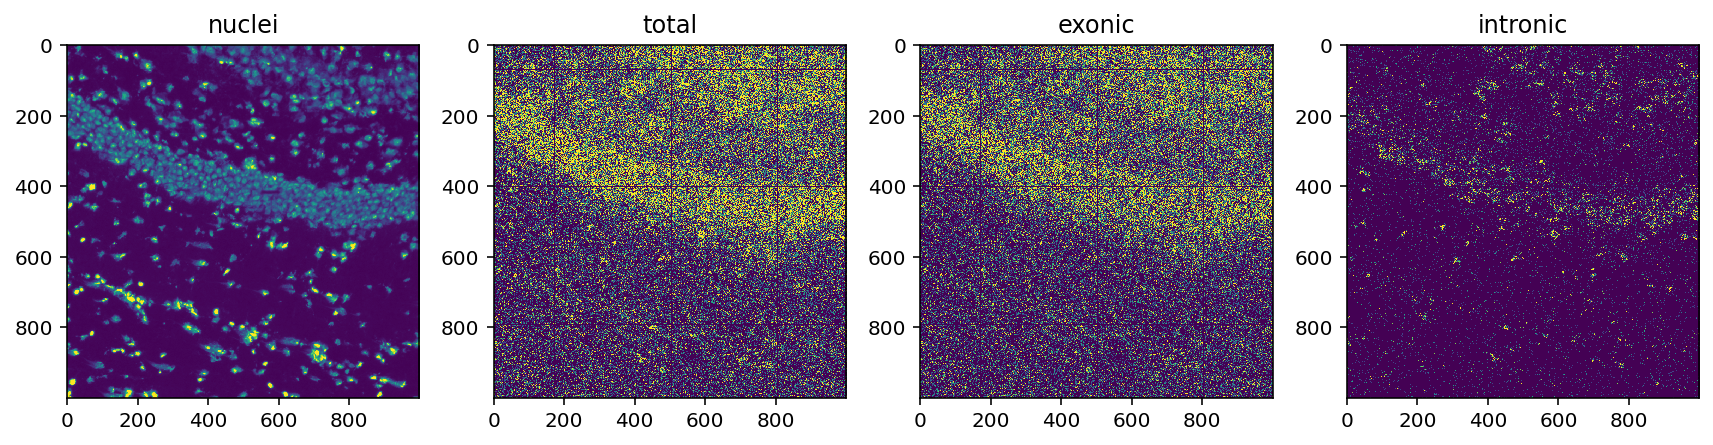

In [3]:
fig, axes = plt.subplots(ncols=4, figsize=(12, 3), tight_layout=True)
axes[0].imshow(tif)
axes[0].set_title('nuclei')
axes[1].imshow(total.A, vmin=0, vmax=5)
axes[1].set_title('total')
axes[2].imshow(exonic.A, vmin=0, vmax=5)
axes[2].set_title('exonic')
axes[3].imshow(intronic.A, vmin=0, vmax=5)
axes[3].set_title('intronic')

## Using nucleus staining results

Text(0.5, 1.0, 'cell segmentation')

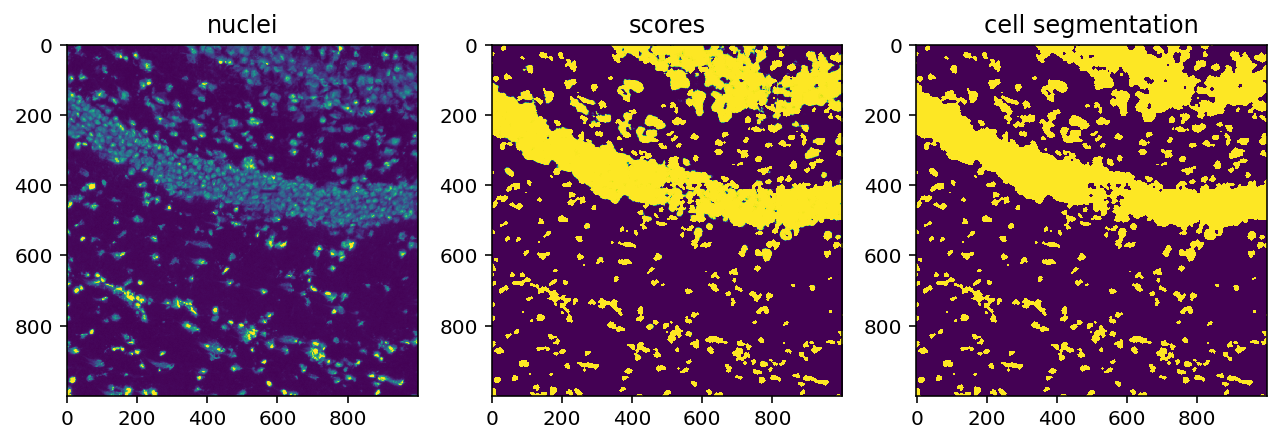

In [49]:
scores = st.pp.segmentation.icell.score_pixels(
    total,
    k=21,
    method='EM+BP',
    em_kwargs=dict(downsample=100000, seed=2022),
    bp_kwargs=dict(n_threads=8, k=3, square=False, p=0.7, q=0.3),
    certain_mask=nuclei_labels > 0
)
thresholds = skimage.filters.threshold_multiotsu(scores, classes=3)
cell_mask = st.pp.segmentation.utils.apply_threshold(scores, 7, thresholds[1])

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), tight_layout=True)
axes[0].imshow(tif)
axes[0].set_title('nuclei')

axes[1].imshow(scores)
axes[1].set_title('scores')

axes[2].imshow(cell_mask)
axes[2].set_title('cell segmentation')

Text(0.5, 1.0, 'enlarged')

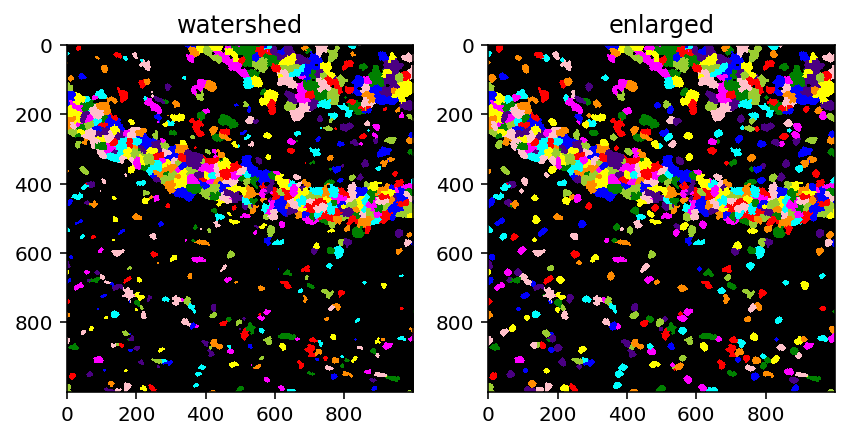

In [52]:
watershed = st.pp.segmentation.label.watershed(total, cell_mask, nuclei_labels, 11)
enlarged = st.pp.segmentation.label.expand_labels(watershed, 5, 400)

fig, axes = plt.subplots(ncols=2, figsize=(6, 3), tight_layout=True)
axes[0].imshow(skimage.color.label2rgb(watershed))
axes[0].set_title('watershed')

axes[1].imshow(skimage.color.label2rgb(enlarged))
axes[1].set_title('enlarged')

## Using RNA-based nucleus segmentation results

Text(0.5, 1.0, 'cell segmentation')

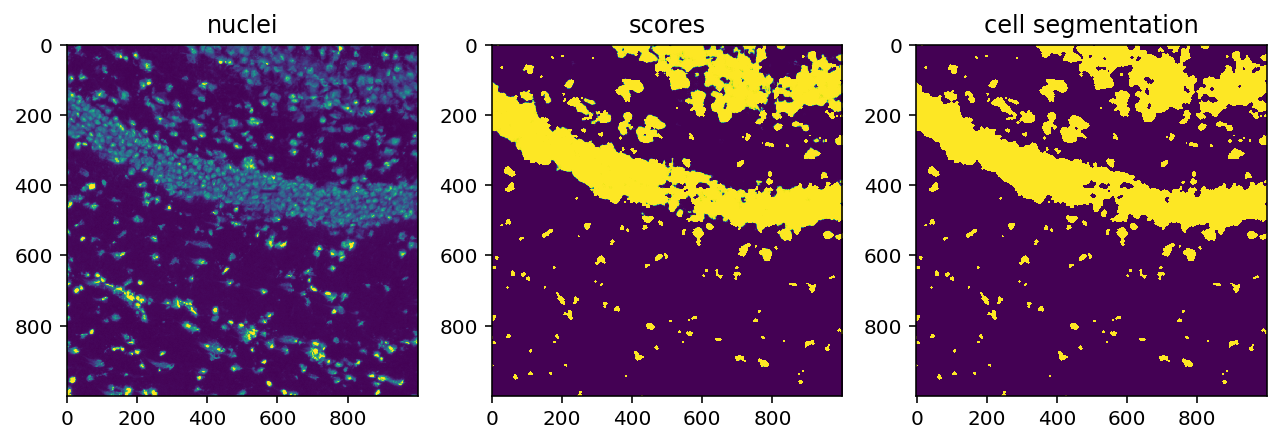

In [54]:
scores = st.pp.segmentation.icell.score_pixels(
    total,
    k=21,
    method='EM+BP',
    em_kwargs=dict(downsample=100000, seed=2022),
    bp_kwargs=dict(n_threads=8, k=3, square=False, p=0.7, q=0.3),
    certain_mask=est_nuclei_labels > 0
)
thresholds = skimage.filters.threshold_multiotsu(scores, classes=3)
est_cell_mask = st.pp.segmentation.utils.apply_threshold(scores, 7, thresholds[1])

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), tight_layout=True)
axes[0].imshow(tif)
axes[0].set_title('nuclei')

axes[1].imshow(scores)
axes[1].set_title('scores')

axes[2].imshow(est_cell_mask)
axes[2].set_title('cell segmentation')

Text(0.5, 1.0, 'enlarged')

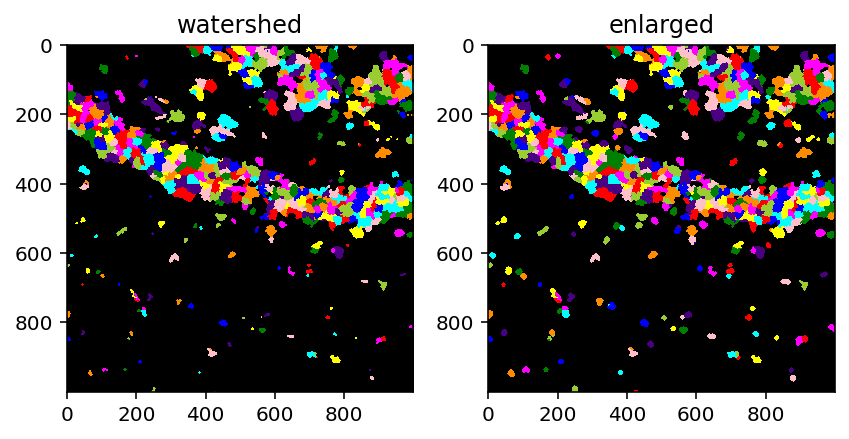

In [56]:
est_watershed = st.pp.segmentation.label.watershed(total, est_cell_mask, nuclei_labels, 11)
est_enlarged = st.pp.segmentation.label.expand_labels(est_watershed, 5, 400)

fig, axes = plt.subplots(ncols=2, figsize=(6, 3), tight_layout=True)
axes[0].imshow(skimage.color.label2rgb(est_watershed))
axes[0].set_title('watershed')

axes[1].imshow(skimage.color.label2rgb(est_enlarged))
axes[1].set_title('enlarged')

## Performance benchmarks

How consistent are the cell labelings between those obtained from stained nuclei and those from RNA-based nucleus segmentation? The metrics shown here are the same with those in `nuclei_segmentation.ipynb`.

Text(0.5, 1.0, 'RNA mask')

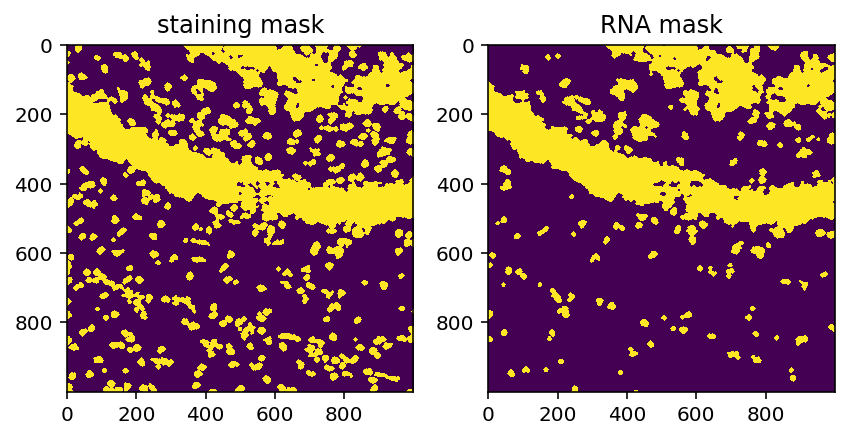

In [62]:
fig, axes = plt.subplots(ncols=2, figsize=(6, 3), tight_layout=True)
enlarged_mask = enlarged > 0
est_enlarged_mask = est_enlarged > 0

axes[0].imshow(enlarged_mask)
axes[0].set_title('staining mask')

axes[1].imshow(est_enlarged_mask)
axes[1].set_title('RNA mask')

In [63]:
y_true, y_pred = enlarged_mask.flatten(), est_enlarged_mask.flatten()
pos = y_true.sum()
neg = (~y_true).sum()
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y_true, y_pred).ravel()
f1_score = sklearn.metrics.f1_score(y_true, y_pred)
print(f'True negative: {tn / neg:.3f}')
print(f'False positive: {fp / neg:.3f}')
print(f'False negative: {fn / pos:.3f}')
print(f'True positive: {tp / pos:.3f}')
print(f'F1 score: {f1_score:.3f}')

True negative: 0.974
False positive: 0.026
False negative: 0.316
True positive: 0.684
F1 score: 0.788


Text(0, 0.5, 'Cell with $\\geq$ capture proportion')

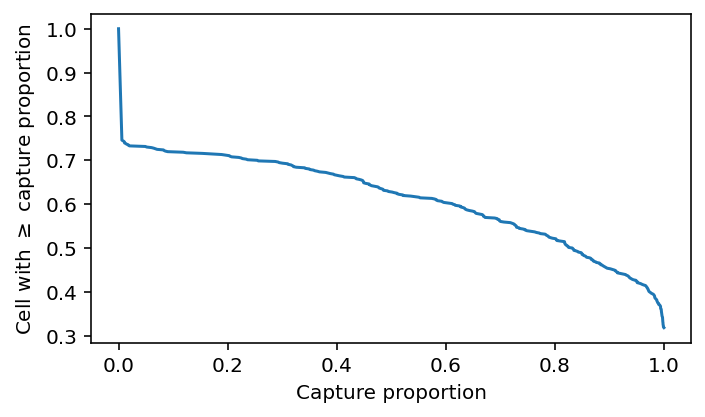

In [65]:
labels = np.unique(enlarged)[1:]
props = []
for label in labels:
    label_mask = enlarged == label
    area = label_mask.sum()
    
    intersect = label_mask & est_enlarged_mask
    intersect_area = intersect.sum()
    
    props.append(intersect_area / area)

unique, counts = np.unique(props, return_counts=True)
fig, ax = plt.subplots(figsize=(5, 3), tight_layout=True)
ax.plot(unique, np.cumsum(counts[::-1])[::-1] / len(props))
ax.set_xlabel('Capture proportion')
ax.set_ylabel('Cell with $\geq$ capture proportion')

Text(0.5, 1.0, 'RNA labels')

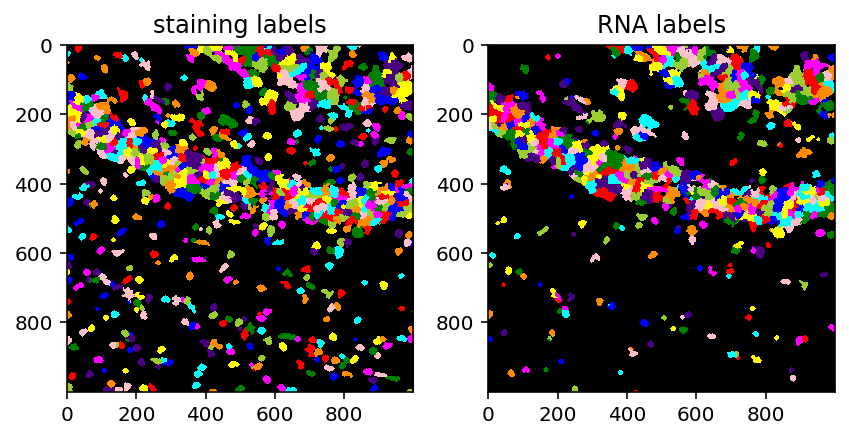

In [60]:
fig, axes = plt.subplots(ncols=2, figsize=(6, 3), tight_layout=True)

axes[0].imshow(skimage.color.label2rgb(enlarged))
axes[0].set_title('staining labels')

axes[1].imshow(skimage.color.label2rgb(est_enlarged))
axes[1].set_title('RNA labels')

Text(0.5, 1.0, 'Adjusted rand score = 0.968')

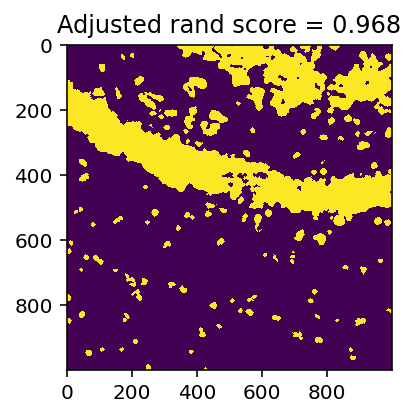

In [58]:
mask = (enlarged > 0) & (est_enlarged > 0)
ars = sklearn.metrics.adjusted_rand_score(
    enlarged.flatten()[mask.flatten()],
    est_enlarged.flatten()[mask.flatten()]
)
fig, ax = plt.subplots(figsize=(3, 3), tight_layout=True)
ax.imshow(mask)
ax.set_title(f'Adjusted rand score = {ars:.3f}')